## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../source/Noise/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from NoiseBayes import NoiseBayes

from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian

# specify which navigation class we are using
from NavigationSegment import NavigationSegment as Navigation
from NavigationMultiSegment import NavigationMultiSegment as NavigationMulti

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_steps = 10000

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.05  # truncation radius for truncation-style measurements

meshDim = 20  # discretization parameter (1D) for FOM
meshDim_drone = 10  # discretization parameter (1D) for subdomain in truncation-type measurements
polyDim = 3

n_test = 100 # resolution for 1D plots

## Setup

In [3]:
tStart = time.time()

# initialize full-order model
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 1, n_steps))

# point-wise measurements
detector = DetectorPointwise(fom)

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

# set noise model
noise = NoiseBayes(grid_t = drone.grid_t)
noise.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 1)
inversion = InverseProblem(fom, drone, noise=noise)

# initialize utility functions
utility = OEDUtility(inversion)

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 0.36939001083374023 s


In [4]:
# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

## Derivative test

We have shown below that the error does not lie in the derivative of the measurements. Hence, we need to go a step up.

In [5]:
alpha_middle = np.array([0.7, 0.5, np.pi/2, 0.4, 1])
# initial-x, initial-y, heading, velocity, angular-velocity

# compute flight
flight = drone.plan_flight(alpha=alpha_middle, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# compute posterior covariance
posterior_ref = inversion.compute_posterior(alpha=alpha_middle)
inv_cov_ref = posterior_ref.compute_inverse_covariance()
d_inv_cov_ref_d_control = posterior_ref.d_invPostCov_d_control()

# measure data
data = drone.measure(flight=flight, state=state)
d_data = drone.d_measurement_d_control(flight=flight, state=state)

/Users/nicole/git/m2dtIceSheet/notebooks/../source/InverseProblem.py:240: UserWarning: InverseProblem.get_states: No saved states. Computing and saving with standard basis.
  warnings.warn(


we are in Posterior.d_invPostCov_d_position


(-0.05, 1.05)

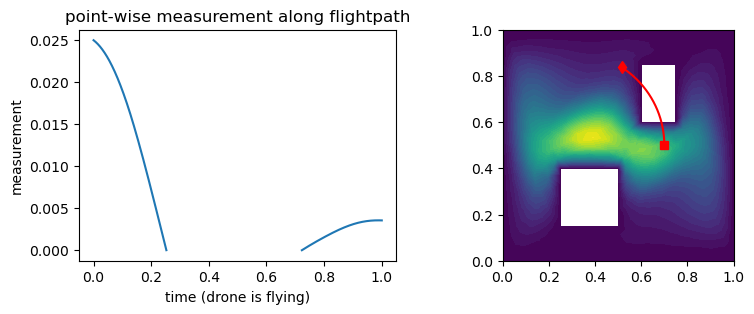

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

axs[0].plot(grid_t, data)
axs[0].set_xlabel("time (drone is flying)")
axs[0].set_ylabel("measurement")
axs[0].set_title("point-wise measurement along flightpath")
axs[0].set_xlim(grid_t[0]-0.05, grid_t[-1]+0.05)

In [7]:
directions = np.zeros((n_test, 5))

directions[:, 0] = np.linspace(0, 1, n_test) # initial x position
directions[:, 1] = np.linspace(0, 1, n_test) # initial y position
directions[:, 2] = np.linspace(0, 2*np.pi, n_test) # initial heading (in radian)
directions[:, 3] = np.linspace(0, 2*alpha_middle[3], n_test) # velocity

yolo = np.max([5, 2*np.abs(alpha_middle[4])])
directions[:, 4] = np.linspace(-yolo, yolo, n_test) # angular velocity

# directions[:, 0] = np.linspace(0.99*alpha_middle[0], 1.01*alpha_middle[0], n_test) # initial x position
# directions[:, 1] = np.linspace(0.99*alpha_middle[1], 1.01*alpha_middle[1], n_test) # initial y position
# directions[:, 2] = np.linspace(0.99*alpha_middle[2], 1.01*alpha_middle[2], n_test) # initial heading (in radian)
# directions[:, 3] = np.linspace(0.99*alpha_middle[3], 1.01*alpha_middle[3], n_test) # velocity
# directions[:, 4] = np.linspace(0.99*alpha_middle[4], 1.01*alpha_middle[4], n_test) # angular velocity

inv_covariances = np.zeros((n_test, 5), dtype = object)
for i in range(n_test):
    if not i % 10: 
        print("iteration {} / {}".format(i+1, n_test))
    
    for j in range(5):
        alpha = alpha_middle.copy()
        alpha[j] = directions[i, j]
        
#         # compute flight
#         flight = drone.plan_flight(alpha=alpha, grid_t=drone.grid_t)  # Flight object
#         flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

        posterior_temp = inversion.compute_posterior(alpha=alpha)
        inv_covariances[i,j] = posterior_temp.compute_inverse_covariance()

iteration 1 / 100
iteration 11 / 100
iteration 21 / 100
iteration 31 / 100
iteration 41 / 100
iteration 51 / 100
iteration 61 / 100
iteration 71 / 100
iteration 81 / 100
iteration 91 / 100


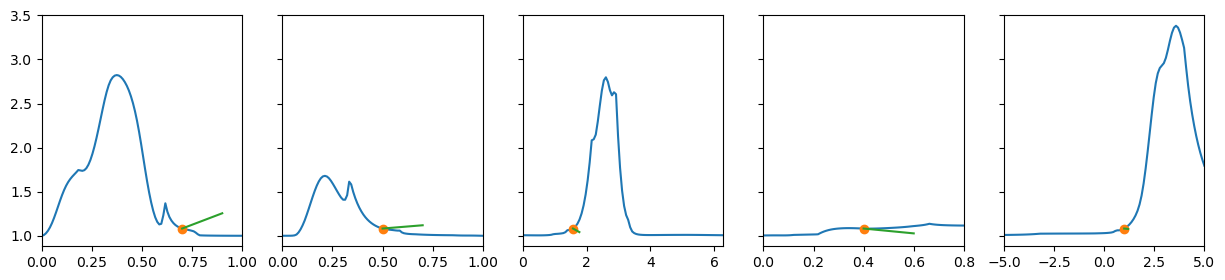

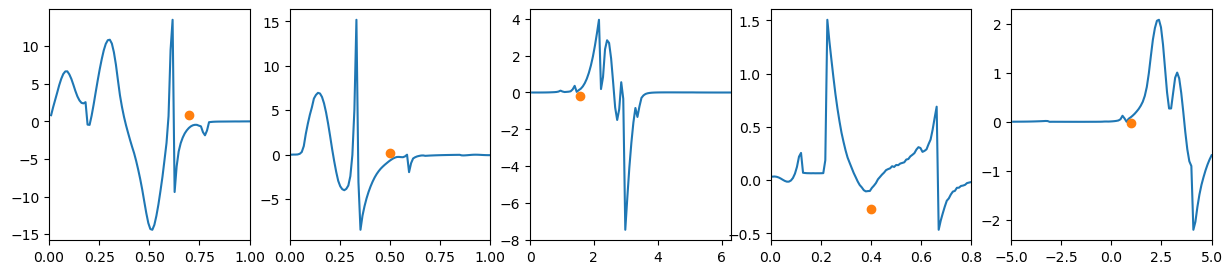

In [8]:
row_test = 0
col_test = 0
eps = 0.2

fig, axs = plt.subplots(1, 5, figsize = (15, 3), sharey=True)
for j in range(5):
    yolo = [inv_covariances[i_iter,j][row_test, col_test] for i_iter in range(n_test)]
    axs[j].plot(directions[:, j], yolo)
    axs[j].plot([alpha_middle[j]], [inv_cov_ref[row_test, col_test]], marker = "o")
    axs[j].plot([alpha_middle[j], alpha_middle[j]+eps], 
                [inv_cov_ref[row_test, col_test], 
                 inv_cov_ref[row_test, col_test] + eps*d_inv_cov_ref_d_control[j, row_test, col_test]])
    
    axs[j].set_xlim(directions[0, j], directions[-1, j])
    

fig, axs = plt.subplots(1, 5, figsize = (15, 3), sharey=False)

for j in range(5):
    yolo = [inv_covariances[i_iter,j][row_test, col_test] for i_iter in range(n_test)]
    yolo = np.array(yolo)
    fd = (yolo[1:]-yolo[:-1])
    yolo = (directions[1, j]-directions[0,j])
    fd /= yolo
    
    axs[j].plot(directions[1:, j], fd)
    axs[j].plot([alpha_middle[j]], [d_inv_cov_ref_d_control[j, row_test, col_test]], marker = "o")
    
    axs[j].set_xlim(directions[0, j], directions[-1, j])

### derivatives of measurements

In [9]:
alpha_middle = np.array([0.9, 0.8, 3, 0.2, 0.5])
# initial-x, initial-y, heading, velocity, angular-velocity

# compute flight
flight = drone.plan_flight(alpha=alpha_middle, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)
d_data = drone.d_measurement_d_control(flight=flight, state=state)

(-0.05, 1.05)

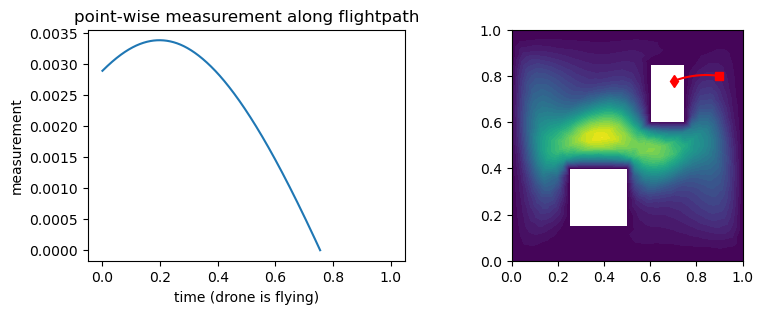

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

axs[0].plot(grid_t, data)
axs[0].set_xlabel("time (drone is flying)")
axs[0].set_ylabel("measurement")
axs[0].set_title("point-wise measurement along flightpath")
axs[0].set_xlim(grid_t[0]-0.05, grid_t[-1]+0.05)

In [11]:
directions = np.zeros((n_test, 5))

# directions[:, 0] = np.linspace(0, 1, n_test) # initial x position
# directions[:, 1] = np.linspace(0, 1, n_test) # initial y position
# directions[:, 2] = np.linspace(0, 2*np.pi, n_test) # initial heading (in radian)
# directions[:, 3] = np.linspace(0, 2*alpha_middle[3], n_test) # velocity

# yolo = np.max([5, 2*np.abs(alpha_middle[4])])
# directions[:, 4] = np.linspace(-yolo, yolo, n_test) # angular velocity

directions[:, 0] = np.linspace(0.99*alpha_middle[0], 1.01*alpha_middle[0], n_test) # initial x position
directions[:, 1] = np.linspace(0.99*alpha_middle[1], 1.01*alpha_middle[1], n_test) # initial y position
directions[:, 2] = np.linspace(0.99*alpha_middle[2], 1.01*alpha_middle[2], n_test) # initial heading (in radian)
directions[:, 3] = np.linspace(0.99*alpha_middle[3], 1.01*alpha_middle[3], n_test) # velocity
directions[:, 4] = np.linspace(0.99*alpha_middle[4], 1.01*alpha_middle[4], n_test) # angular velocity

measurements = np.zeros((n_test, 5, n_steps))
for i in range(n_test):
    if not i % 10: 
        print("iteration {} / {}".format(i+1, n_test))
    
    for j in range(5):
        alpha = alpha_middle.copy()
        alpha[j] = directions[i, j]
        
        # compute flight
        flight = drone.plan_flight(alpha=alpha, grid_t=drone.grid_t)  # Flight object
        flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

        # measure data
        measurements[i,j, :] = drone.measure(flight=flight, state=state)

iteration 1 / 100
iteration 11 / 100
iteration 21 / 100
iteration 31 / 100
iteration 41 / 100
iteration 51 / 100
iteration 61 / 100
iteration 71 / 100
iteration 81 / 100
iteration 91 / 100


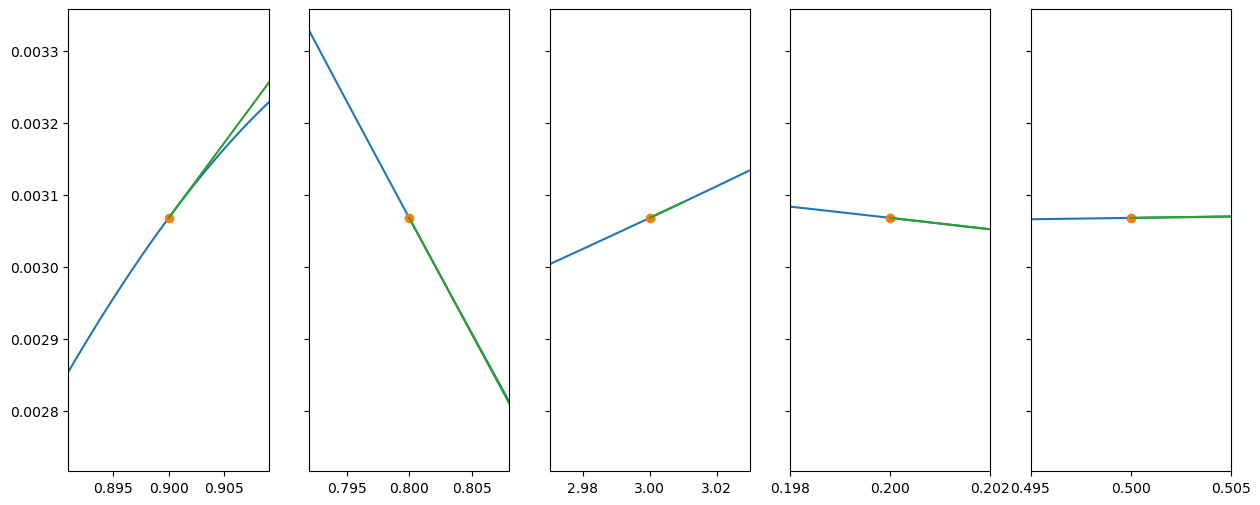

In [12]:
k_test = 3500
eps = 1e-2

fig, axs = plt.subplots(1, 5, figsize = (15, 6), sharey=True)

for j in range(5):
    axs[j].plot(directions[:, j], measurements[:, j, k_test])
    axs[j].plot([alpha_middle[j]], [data[k_test]], marker = "o")
    axs[j].plot([alpha_middle[j], alpha_middle[j]+eps], [data[k_test], data[k_test] + eps*d_data[k_test, j]])
    
    axs[j].set_xlim(directions[0, j], directions[-1, j])

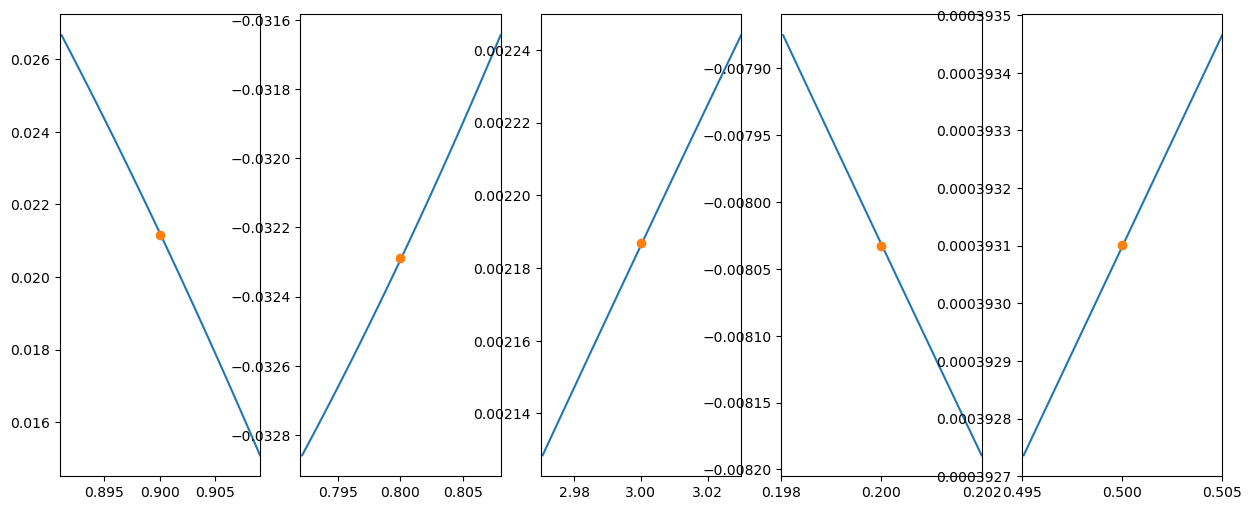

In [13]:
k_test = 3519

fig, axs = plt.subplots(1, 5, figsize = (15, 6), sharey=False)

for j in range(5):
    yolo = (directions[1, j]-directions[0,j])
    fd = (measurements[1:, j, k_test]-measurements[:-1, j, k_test])
    fd /= yolo
    
    axs[j].plot(directions[1:, j], fd)
    axs[j].plot([alpha_middle[j]], [d_data[k_test, j]], marker = "o")
#     axs[j].plot([alpha_middle[j]], [data[k_test]], marker = "o")
#     axs[j].plot([alpha_middle[j], alpha_middle[j]+eps], [data[k_test], data[k_test] + eps*d_data[k_test, j]])


    axs[j].set_xlim(directions[0, j], directions[-1, j])

**Welcome back!** 
I've fixed a bug in the computation of `d_measurement_d_position`, and those derivatives look correct now, but `d_utility_d_control` still does not match the finite difference approximation (see notebook 7, v3). 

The issue only occurs when the flightpath strays outside the modelled domain, and is caused by the boundary conditions of the time integration (remember: the ones that are 0 normally because we are not varying over 0 and the final time T). When the flightpath goes outside of the modelled domain, we are cutting parts out of the time integration, and we need to consider the derivative of the time of these cuts.

Luckily it looks like the error is not actually that grave in the grant scheme of things, especially since the optimization is constrained to remain inside the domain, but it's something I should figure out at some point.